<a href="https://colab.research.google.com/github/Yannik-H/Code-expamles-for-Advanced-Machine-Learning/blob/master/House_Prices(20/7/26).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%tensorflow_version 1.x
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import numpy as np
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train_data = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/train.csv', index_col=0)
test_data = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/test.csv', index_col=0)
submission = pd.read_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/sample_submission.csv', index_col=0)

# Data visualization

In [4]:
Prices = train_data['SalePrice']
y = Prices
FE_c_columns = [col for col in train_data.columns if train_data[col].dtype == 'object']
FE_n_columns = train_data.columns.drop(FE_c_columns)
FE_c_data = train_data[FE_c_columns]
FE_n_data = train_data[FE_n_columns.drop('SalePrice')]
FE_c_data.insert(0,'SalePrice', Prices)
FE_n_data.insert(0, 'SalePrice', Prices)

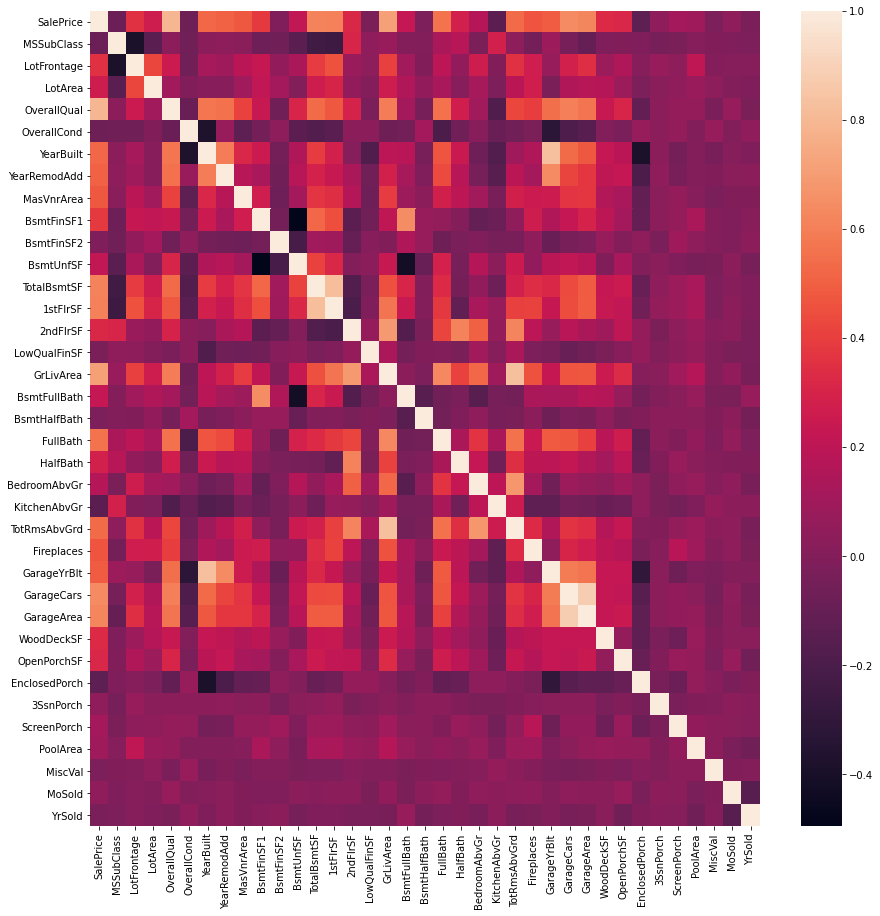

In [5]:
n_corr = FE_n_data.corr() #'Pearson'
plt.figure(figsize=(15,15))
sns.heatmap(n_corr, xticklabels=n_corr.columns.values, yticklabels=n_corr.columns.values)

In [6]:
Prices_related_n_features = [col for col in n_corr.columns if n_corr.loc['SalePrice'][col] >= 0.5]
Prices_unrelated_n_features = FE_n_data.columns.drop(Prices_related_n_features).values

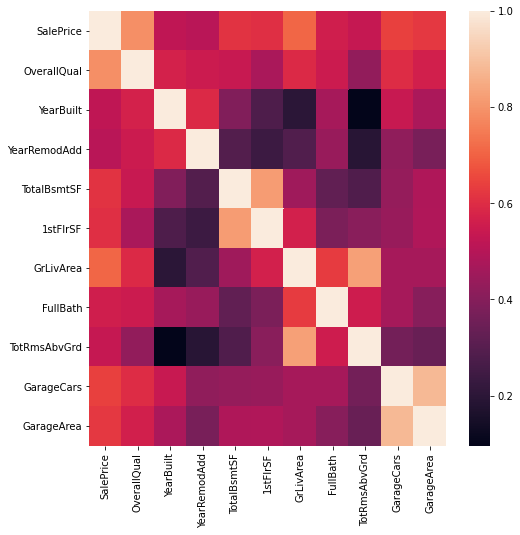

In [7]:
plt.figure(figsize=(8,8))
sns.heatmap(n_corr[Prices_related_n_features].loc[Prices_related_n_features], 
            xticklabels=n_corr[Prices_related_n_features].columns.values, 
            yticklabels=n_corr[Prices_related_n_features].columns.values)
Prices_related_n_features = Prices_related_n_features[1:]

In [8]:
n_corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

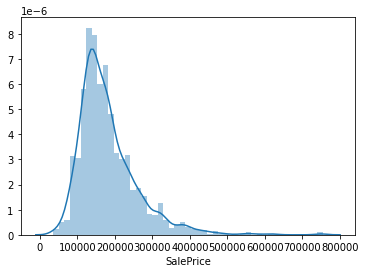

In [9]:
sns.distplot(Prices)
#SalePrice 不符合正态分布

In [10]:
Prices_related_n_features

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

看SalePrice 和 OverallQual的关系

*OverallQual: Rates the overall material and finish of the house*
```
  10   Very Excellent
  9	Excellent
  8	Very Good
  7	Good
  6	Above Average
  5	Average
  4	Below Average
  3	Fair
  2	Poor
  1	Very Poor
```



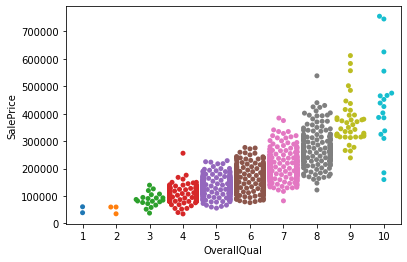

In [11]:
S_O = train_data[['SalePrice', 'OverallQual']]
sns.swarmplot(x=S_O['OverallQual'], y=S_O['SalePrice'])

**SalePrice 和 GarageCars 之间的关系**

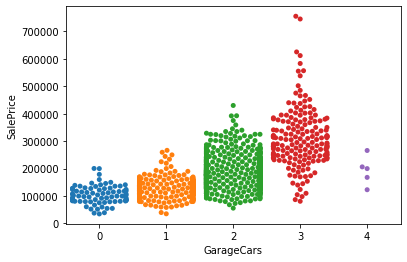

In [12]:
S_GC= train_data[['SalePrice', 'GarageCars']]
sns.swarmplot(S_GC['GarageCars'], S_GC['SalePrice'])

**SalePrice 和 TotalBsmtSF(*Total square feet of basement area*) 之间的关系**

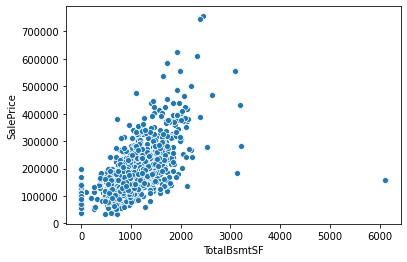

In [13]:
S_T = train_data[['SalePrice', 'TotalBsmtSF']]
sns.scatterplot(S_T['TotalBsmtSF'], S_T['SalePrice'])
#有一个离群点在右下角

SalePrice 和 GrLivArea(*GrLivArea: Above grade (ground) living area square feet*) 的关系

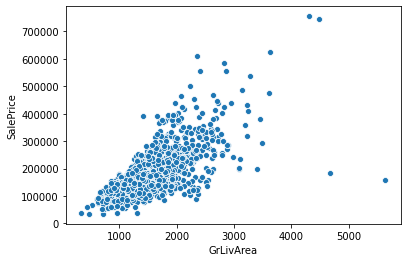

In [14]:
S_G = train_data[['SalePrice', 'GrLivArea']]
sns.scatterplot(x=S_G['GrLivArea'], y=S_G['SalePrice'])
#右下角有离群点

# Data Imputation

In [15]:
def missing_values(full_data):
    alldata_na = pd.DataFrame(full_data.isnull().sum(), columns={'missingNum'})
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(full_data)*100
    alldata_na['existNum'] = len(full_data) - alldata_na['missingNum']
    
    alldata_na['train_notna'] = len(train_data) - train_data.isnull().sum()
    alldata_na['test_notna'] = alldata_na['existNum'] - alldata_na['train_notna'] 
    alldata_na['dtype'] = full_data.dtypes
    
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na


In [16]:
full_data = pd.concat((train_data.loc[:,'MSSubClass':'SaleCondition'], test_data.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)
na_info = missing_values(full_data)
na_info

,missingNum,missingRatio,existNum,train_notna,test_notna,dtype
index,,,,,,
PoolQC,2909,99.657417,10,7,3,object
MiscFeature,2814,96.402878,105,54,51,object
Alley,2721,93.216855,198,91,107,object
Fence,2348,80.438506,571,281,290,object
FireplaceQu,1420,48.646797,1499,770,729,object
LotFrontage,486,16.649538,2433,1201,1232,float64
GarageCond,159,5.447071,2760,1379,1381,object
GarageFinish,159,5.447071,2760,1379,1381,object
GarageQual,159,5.447071,2760,1379,1381,object


处理PoolQC

In [17]:
Pool = pd.concat([train_data[['PoolArea', 'PoolQC']], test_data[['PoolArea', 'PoolQC']]])
#print("不空的PoolQC数量为" % len(Pool.loc[Pool['PoolQC'].notnull()]))

avg_pool = Pool.groupby('PoolQC').agg([len])
avg_pool['mean'] = Pool.groupby('PoolQC').mean()
avg_pool
#这实在是太没代表性了，我觉得不填比较好点

,PoolArea,mean
,len,
PoolQC,,
Ex,4,359.75
Fa,2,583.50
Gd,4,648.50


In [18]:
full_data = full_data[full_data.columns.drop('PoolQC')]

处理FireplaceQu

In [19]:
FirePlace = pd.concat([train_data[['Fireplaces', 'FireplaceQu']], test_data[['Fireplaces', 'FireplaceQu']]])
len(FirePlace.loc[FirePlace.FireplaceQu.isnull() & FirePlace.Fireplaces.notnull() & FirePlace.Fireplaces != 0]) #观察是不是有遗漏数据
#没有遗漏数据，直接把Na换成字符串就行了
full_data.FireplaceQu = full_data.FireplaceQu.fillna('None')

处理Fence(*Fence quality*)



```
   GdPrv   Good Privacy
   MnPrv   Minimum Privacy
   GdWo	Good Wood
   MnWw	Minimum Wood/Wire
   NA	  No Fence
```



In [20]:
Fence = full_data['Fence']
Fence.loc[Fence.notnull()].value_counts()
#NA填充为0，MnWw、GdWo为一类，且有先后之分；MnPrv、GdPrv为一类，且有先后之分

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

In [21]:
full_data.Fence = full_data.Fence.fillna('None')

### 处理 Garage* 相关空值

In [22]:
col = pd.Series(train_data.columns)
garage_col = col[col.str.contains('Garage')].values
garage = full_data[garage_col]
na_info.loc[garage_col]
#GarageType有两个Na值没出现

,missingNum,missingRatio,existNum,train_notna,test_notna,dtype
index,,,,,,
GarageType,157,5.378554,2762,1379,1383,object
GarageYrBlt,159,5.447071,2760,1379,1381,float64
GarageFinish,159,5.447071,2760,1379,1381,object
GarageCars,1,0.034258,2918,1460,1458,float64
GarageArea,1,0.034258,2918,1460,1458,float64
GarageQual,159,5.447071,2760,1379,1381,object
GarageCond,159,5.447071,2760,1379,1381,object


In [23]:
garage.loc[garage['GarageType'].notnull() & garage['GarageFinish'].isnull()]
#这两个值的GarageType, GarageCars, GarageArea应该填为0.0

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
2126,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
2576,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
garage.loc[2126, 'GarageType'] = np.nan
garage.loc[2576, 'GarageType'] = np.nan

garage.loc[2126, 'GarageCars'] = np.nan
garage.loc[2126, 'GarageArea'] = np.nan

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [25]:
garage_o_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garage[garage_o_cols] = garage[garage_o_cols].fillna('None')
garage_n_cols = ['GarageCars', 'GarageArea']
garage[garage_n_cols] = garage[garage_n_cols].fillna(0.0)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [26]:
garage.loc[garage['GarageYrBlt'].isnull()]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,None,NaN,None,0.0,0.0,None,None
48,None,NaN,None,0.0,0.0,None,None
78,None,NaN,None,0.0,0.0,None,None
88,None,NaN,None,0.0,0.0,None,None
89,None,NaN,None,0.0,0.0,None,None
...,...,...,...,...,...,...,...
2893,None,NaN,None,0.0,0.0,None,None
2909,None,NaN,None,0.0,0.0,None,None
2913,None,NaN,None,0.0,0.0,None,None
2914,None,NaN,None,0.0,0.0,None,None


In [27]:
full_data[garage_col] = garage[garage_col].copy()

### 处理Bsmt*相关空值

In [28]:
Bsmt_col = col[col.str.contains('Bsmt')].values
bsmt = full_data[Bsmt_col]
na_info.loc[Bsmt_col]

,missingNum,missingRatio,existNum,train_notna,test_notna,dtype
index,,,,,,
BsmtQual,81,2.774923,2838,1423,1415,object
BsmtCond,82,2.809181,2837,1423,1414,object
BsmtExposure,82,2.809181,2837,1422,1415,object
BsmtFinType1,79,2.706406,2840,1423,1417,object
BsmtFinSF1,1,0.034258,2918,1460,1458,float64
BsmtFinType2,80,2.740665,2839,1422,1417,object
BsmtFinSF2,1,0.034258,2918,1460,1458,float64
BsmtUnfSF,1,0.034258,2918,1460,1458,float64
TotalBsmtSF,1,0.034258,2918,1460,1458,float64


In [29]:
bsmt.loc[bsmt['BsmtQual'].isnull() | bsmt['BsmtCond'].isnull() |bsmt['BsmtExposure'].isnull() | 
         bsmt['BsmtFinType1'].isnull() | bsmt['BsmtFinType2'].isnull()]
#有88个，说明有些NaN是错填的

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
17,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
39,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
90,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
102,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
156,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2803,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2804,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2824,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
2891,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0


In [30]:
na_b_index = bsmt.loc[bsmt['BsmtQual'].isnull() & bsmt['BsmtCond'].isnull() & bsmt['BsmtExposure'].isnull() & 
         bsmt['BsmtFinType1'].isnull() & bsmt['BsmtFinType2'].isnull()].index
o_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
def fill(row):
  row = row.fillna("None")
  return row
bsmt.loc[na_b_index, o_cols] = bsmt.loc[na_b_index, o_cols].apply(fill, axis='columns')
#这79个一定是没Bsmt的，类别列填上"NoBasement"
bsmt.loc[na_b_index, o_cols]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,None,None,None,None,None
39,None,None,None,None,None
90,None,None,None,None,None
102,None,None,None,None,None
156,None,None,None,None,None
...,...,...,...,...,...
2803,None,None,None,None,None
2804,None,None,None,None,None
2824,None,None,None,None,None
2891,None,None,None,None,None


In [31]:
#填完后只剩9个错填的数据有错填的NaN，这些空值考虑填所在列的众数（将来可考虑通过协同过滤来使用其他Bsmt值预测进行填充）
bsmt.loc[bsmt['BsmtQual'].isnull() | bsmt['BsmtCond'].isnull() |bsmt['BsmtExposure'].isnull() | 
         bsmt['BsmtFinType1'].isnull() | bsmt['BsmtFinType2'].isnull()]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0
948,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
1487,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
2040,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
2185,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
2217,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
2218,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0
2348,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
2524,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [32]:
na_n_bsmt_index = bsmt.loc[bsmt['BsmtQual'].isnull() | bsmt['BsmtCond'].isnull() |bsmt['BsmtExposure'].isnull() | 
         bsmt['BsmtFinType1'].isnull() | bsmt['BsmtFinType2'].isnull()].index
bsmt_imputed = SimpleImputer(strategy='most_frequent')
temp = pd.DataFrame(bsmt_imputed.fit_transform(bsmt[o_cols]))
temp.colums = o_cols
temp.index = bsmt.index
bsmt[o_cols] = temp.copy()
bsmt.loc[na_n_bsmt_index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124.0,Unf,479.0,1603.0,3206.0,1.0,0.0
948,Gd,TA,No,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
1487,Gd,TA,No,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
2040,Gd,TA,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,1.0,0.0
2185,TA,TA,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,0.0,1.0
2217,TA,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
2218,TA,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0
2348,Gd,TA,No,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
2524,TA,TA,Av,ALQ,755.0,Unf,0.0,240.0,995.0,0.0,0.0


In [33]:
bsmt.loc[bsmt['BsmtFinSF1'].isnull() | bsmt['BsmtFinSF2'].isnull() | bsmt['BsmtUnfSF'].isnull() |
         bsmt['TotalBsmtSF'].isnull() | bsmt['BsmtFullBath'].isnull() | bsmt['BsmtHalfBath'].isnull()]
#全填0就行了

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2120,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN
2188,None,None,None,None,0.0,None,0.0,0.0,0.0,NaN,NaN


In [34]:
bsmt_n_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
bsmt[bsmt_n_col] = bsmt[bsmt_n_col].fillna(0.0)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [35]:
full_data[Bsmt_col] = bsmt.copy()

处理 Alley(Type of alley access to property)



```
   Grvl	Gravel
   Pave	Paved
   NA 	 No alley access
```



In [36]:
#直接填上 NoAlley 就行了
full_data['Alley'] = full_data['Alley'].fillna('None')

处理LotFrontage(*Linear feet of street connected to property*)

In [37]:
lotfrontage = full_data[['LotFrontage', 'Neighborhood']]

In [38]:
lotfrontage.loc[lotfrontage.LotFrontage.isnull()]

,LotFrontage,Neighborhood
7,NaN,NWAmes
12,NaN,Sawyer
14,NaN,NAmes
16,NaN,NAmes
24,NaN,Sawyer
...,...,...
2847,NaN,CollgCr
2850,NaN,CollgCr
2900,NaN,Timber
2901,NaN,Timber


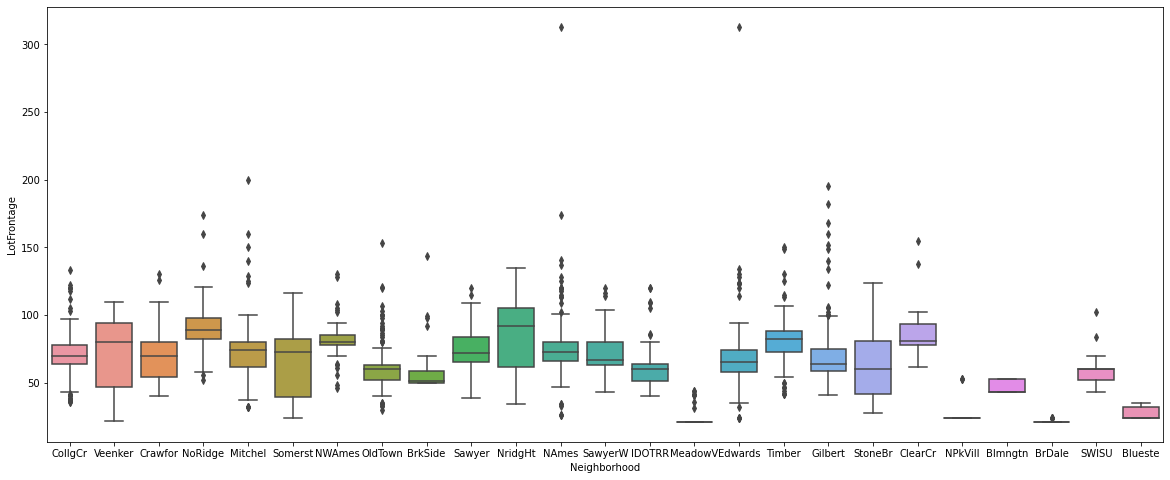

In [39]:
#plt.figure(figsize=(15,6))
#sns.distplot(test.LotFrontage)
#plt.figure()
#res = stats.probplot(test.LotFrontage, plot=plt)
plt.figure(figsize=(20,8))
sns.boxplot(lotfrontage.Neighborhood, lotfrontage.LotFrontage)
#填各自邻居的均值

In [40]:
na_lot_index = lotfrontage.loc[lotfrontage.LotFrontage.isnull()].index
nbh_mean = lotfrontage.groupby('Neighborhood').LotFrontage.mean()
def fill_lot(row):
  row.LotFrontage = nbh_mean.loc[row.Neighborhood]
  return row
lotfrontage.loc[na_lot_index] = lotfrontage.loc[na_lot_index].apply(fill_lot, axis='columns')
full_data.LotFrontage = lotfrontage['LotFrontage'].copy()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


处理 MasVnr*


```
MasVnrType:
   BrkCmn	Brick Common
   BrkFace   Brick Face
   CBlock	Cinder Block
   None	  None
   Stone	 Stone

MasVnrArea:  Masonry veneer area in square feet
```



In [41]:
MasVnr = full_data[['MasVnrType', 'MasVnrArea']]
MasVnr.loc[MasVnr.MasVnrArea.notnull() & MasVnr.MasVnrType.isnull()]
#这里有个奇怪的值, 直接选择填'BrkFace'了

,MasVnrType,MasVnrArea
2610,NaN,198.0


In [42]:
MasVnr.loc[2610, 'MasVnrType'] = 'BrkFace'
MasVnr.MasVnrType = MasVnr.MasVnrType.fillna('None')
MasVnr.MasVnrArea = MasVnr.MasVnrArea.fillna(0.0)
full_data[['MasVnrType', 'MasVnrArea']] = MasVnr.copy()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


处理 MSZoing

In [43]:
# Neighborhood 所在的区域是怎样的肯定空值的也是怎样的
ms = full_data[['MSZoning', 'Neighborhood']]
ms.loc[ms.MSZoning.isnull()]

,MSZoning,Neighborhood
1915,NaN,IDOTRR
2216,NaN,IDOTRR
2250,NaN,IDOTRR
2904,NaN,Mitchel


In [44]:
ms.groupby(['Neighborhood', 'MSZoning']).MSZoning.agg([len])

len
Neighborhood MSZoning     
Blmngtn      RL         25
             RM          3
Blueste      RM         10
BrDale       RM         30
BrkSide      RL         43
             RM         65
ClearCr      RL         44
CollgCr      RL        253
             RM         14
Crawfor      RH          2
             RL         91
             RM         10
Edwards      RH          2
             RL        180
             RM         12
Gilbert      RL        165
IDOTRR       C (all)    22
             RM         68
MeadowV      RM         37
Mitchel      RL        104
             RM          9
NAmes        RH          7
             RL        436
NPkVill      RL         23
NWAmes       RL        131
NoRidge      RL         71
NridgHt      RL        165
             RM          1
OldTown      C (all)     2
             RL         39
             RM        198
SWISU        C (all)     1
             RH          9
             RL         38
Sawyer       RL        148
             RM          3
SawyerW      RH          6
             RL        119
Somerst      FV        139
             RL         43
StoneBr      RL         51
Timber       RL         72
Veenker      RL         24

In [45]:
def fill_ms(row):
  if row.Neighborhood == 'IDOTRR':
    row.MSZoning = 'RM'
  if row.Neighborhood == 'Mitchel':
    row.MSZoning = 'RL'
  return row

ms.loc[ms.MSZoning.isnull()] = ms.loc[ms.MSZoning.isnull()].apply(fill_ms, axis='columns')

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
full_data['MSZoning'] = ms['MSZoning'].copy()

处理MiscFeature

In [47]:
full_data['MiscFeature'] = full_data['MiscFeature'].fillna('None')

处理杂项

In [48]:
extra_na = missing_values(full_data)
extra_na

,missingNum,missingRatio,existNum,train_notna,test_notna,dtype
index,,,,,,
GarageYrBlt,159,5.447071,2760,1379,1381,float64
Functional,2,0.068517,2917,1460,1457,object
Utilities,2,0.068517,2917,1460,1457,object
Electrical,1,0.034258,2918,1459,1459,object
Exterior1st,1,0.034258,2918,1460,1458,object
Exterior2nd,1,0.034258,2918,1460,1458,object
KitchenQual,1,0.034258,2918,1460,1458,object
SaleType,1,0.034258,2918,1460,1458,object


In [49]:
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
extra_na_cols = extra_na.index.drop('GarageYrBlt')
temp = pd.DataFrame(most_frequent_imputer.fit_transform(full_data[extra_na_cols]))
temp.columns = extra_na_cols
temp.index = full_data.index
full_data[extra_na_cols] = temp.copy()

# Data Preprocessing

In [50]:
full_data.shape
#0~1459都是训练集，1460~2919是测试集
#原来有79个特征，扔掉了个PoolQC

(2919, 78)

In [51]:
full_data.loc[[2126,2576]][garage_col]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
2126,None,NaN,None,0.0,0.0,None,None
2576,None,NaN,None,0.0,0.0,None,None


## 类别特征

In [52]:
c_columns = [col for col in full_data.columns if full_data[col].dtype == 'object']
c_columns

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

### 内部有次序的特征

In [53]:
ordered_feature_cols = ['ExterQual', 'ExterCond', 'GarageQual', 'GarageCond', 
                        'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtQual','BsmtCond']
ordered_map = {'Ex': 5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1,'None': 0}

for col in ordered_feature_cols:
  full_data[col] = full_data[col].map(ordered_map)

In [54]:
#不是使用以上评判标准的有序类别特征
full_data['BsmtExposure'] = full_data['BsmtExposure'].map({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})    
full_data['BsmtFinType1'] = full_data['BsmtFinType1'].map({'None':0, 'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
full_data['BsmtFinType2'] = full_data['BsmtFinType2'].map({'None':0, 'Unf':1, 'LwQ':2,'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
full_data['Functional'] = full_data['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})
full_data['GarageFinish'] = full_data['GarageFinish'].map({'None':0, 'Unf':1, 'RFn':2, 'Fin':3})
full_data['Fence'] = full_data['Fence'].map({'None':0, 'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4})
full_data['CentralAir'] = full_data['CentralAir'].map({'N':0, 'Y':1})
full_data['PavedDrive'] = full_data['PavedDrive'].map({'N':0, 'P':1, 'Y':2})

In [55]:
#对一些特征进行二值化,或根据价格减少类别
full_data['MasVnrType'] = full_data['MasVnrType'].map({'None':0, 'Stone':1, 'CBlock':1, 
                                                       'BrkFace':1, 'BrkCmn':1})
full_data['MiscFeature'] = full_data['MiscFeature'].map({'None':0, 'Elev':1, 'Gar2':1, 
                                                         'Othr':1, 'Shed':1, 'TenC':1})
full_data['SaleCondition'] = full_data['SaleCondition'].map({'Abnorml':0,'Alloca':0, 
                                                             'AdjLand':0,'Family':0,'Partial':0,'Normal':1})
full_data['MSZoning'] = full_data['MSZoning'].map({'RL':2, 'RM':1, 'C (all)': 0, 'FV':1.5, 'RH':0})
full_data['LandSlope'] = full_data['LandSlope'].map({'Sev':0, 'Mod':1, 'Gtl':1})
full_data['MSSubClass'] = full_data['MSSubClass'].astype(str)

In [56]:
#处理年份
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
full_data['GarageYrBlt'] =full_data['GarageYrBlt'].map(year_map)
full_data['GarageYrBlt']= full_data['GarageYrBlt'].fillna('None')
full_data['YearBuilt'] =full_data['YearBuilt'].map(year_map)
full_data['YearRemodAdd'] =full_data['YearRemodAdd'].map(year_map)
full_data['YrSold'] =full_data['YrSold'].map(year_map)

In [57]:
year_map = {'None':0, 'YearGroup1':1, 'YearGroup2':2, 'YearGroup3':3, 'YearGroup4':4, 
            'YearGroup5':5, 'YearGroup6':6, 'YearGroup7':7}
full_data['GarageYrBlt'] = full_data['GarageYrBlt'].map(year_map)
full_data['YearBuilt'] = full_data['YearBuilt'].map(year_map)
full_data['YearRemodAdd'] = full_data['YearRemodAdd'].map(year_map)
full_data['YrSold'] = full_data['YrSold'].map(year_map)

### 内部无次序的特征

In [58]:
pip install category_encoders

In [59]:
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [60]:
c_columns = [col for col in full_data.columns if full_data[col].dtype == 'object']
oh_cols = [col for col in c_columns if len(full_data[col].value_counts()) <= 4]

count_enc = ce.CountEncoder(handle_missing='error')
c_without_oh = full_data[c_columns].drop(oh_cols, axis=1).columns
full_data[c_without_oh] = count_enc.fit_transform(full_data[c_columns].drop(oh_cols, axis=1))

In [61]:
oh_enc = ce.OneHotEncoder(handle_unknown='ignore')
oh_features = oh_enc.fit_transform(full_data[oh_cols])
encoed_features = full_data.drop(oh_cols, axis=1).join(oh_features)

## 数值特征

### Box-Cov变换

In [62]:
from scipy import stats
from scipy.special import boxcox1p

n = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
     '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
     'EnclosedPorch']
#lam = 0.15

for col in n:
  encoed_features[col] = stats.boxcox(encoed_features[col] + 1, lmbda=0.15)

In [63]:
#对 SalePrice 进行log1p变换(反变换expm1)
Prices = np.log1p(Prices)

### 多项式特征

In [64]:
from sklearn.preprocessing import PolynomialFeatures
area_poly_cols = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
garage_poly_cols = ['GarageYrBlt', 'GarageCars', 'GarageArea']

area_poly = PolynomialFeatures(interaction_only=True, include_bias=False)
garage_poly = PolynomialFeatures(interaction_only=True, include_bias=False)

In [65]:
garage_poly_features = garage_poly.fit_transform(encoed_features[garage_poly_cols])[:, 3:]
area_poly_features = area_poly.fit_transform(encoed_features[area_poly_cols])[:, 5:]

### 最终数据集

In [68]:
encoed_features.shape

(2919, 88)

In [69]:
processed_features = np.array(encoed_features)
processed_features = np.hstack((processed_features, area_poly_features))
processed_features = np.hstack((processed_features, garage_poly_features))

In [70]:
X_train = processed_features[:1460, :]
X_test = processed_features[1460:, :]

In [80]:
y = np.array(Prices)
y_train = y[:, np.newaxis]

In [81]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1460, 101)
(1460, 1)
(1459, 101)


# Training and Predicting

In [73]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
  rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
  return rmse

## XGBoost

In [74]:
from xgboost import XGBRegressor

In [ ]:
"""
my_xgbregressor = XGBRegressor(colsample_bytree=0.4,
                 gamma=0.045,
                 learning_rate=0.05,
                 max_depth=20,
                 min_child_weight=1.5,
                 n_estimators=300,
                 reg_alpha=0.65,
                 reg_lambda=0.45,
                 subsample=0.95)
my_xgbregressor.fit(X_train, y_train)
"""

[08:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.045,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=1.5, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.65, reg_lambda=0.45, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.95, verbosity=1)

In [82]:
my_xgbregressor = XGBRegressor(learning_rate=0.05, n_estimators=500)
my_xgbregressor.fit(X_train, y_train)

[15:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
n_of_estimators = np.linspace(50, 500, 46, dtype=int)
xgb_score = []
count = 0

for e in n_of_estimators:
  my_xgbregressor = XGBRegressor(learning_rate=0.05, n_estimators=e, verbosity=0)
  my_xgbregressor.fit(X_train, y_train)
  xgb_score.append(rmse_cv(my_xgbregressor).mean())
  count += 1
  print('-----%.2f%%-----' % ((count/46)*100))

-----2.17%-----
-----4.35%-----
-----6.52%-----
-----8.70%-----
-----10.87%-----
-----13.04%-----
-----15.22%-----
-----17.39%-----
-----19.57%-----
-----21.74%-----
-----23.91%-----
-----26.09%-----
-----28.26%-----
-----30.43%-----
-----32.61%-----
-----34.78%-----
-----36.96%-----
-----39.13%-----
-----41.30%-----
-----43.48%-----
-----45.65%-----
-----47.83%-----
-----50.00%-----
-----52.17%-----
-----54.35%-----
-----56.52%-----
-----58.70%-----
-----60.87%-----
-----63.04%-----
-----65.22%-----
-----67.39%-----
-----69.57%-----
-----71.74%-----
-----73.91%-----
-----76.09%-----
-----78.26%-----
-----80.43%-----
-----82.61%-----
-----84.78%-----
-----86.96%-----
-----89.13%-----
-----91.30%-----
-----93.48%-----
-----95.65%-----
-----97.83%-----
-----100.00%-----


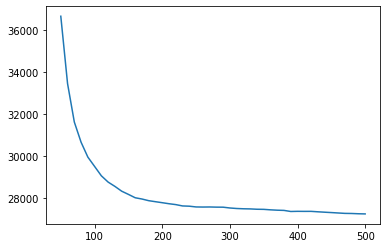

In [ ]:
sns.lineplot(n_of_estimators, xgb_score)

In [83]:
xgb_score = rmse_cv(my_xgbregressor)
print(xgb_score.mean())

[15:56:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:56:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.12831342556503098


In [84]:
prices_prediction = my_xgbregressor.predict(X_test)

In [85]:
prices_prediction = prices_prediction[:, np.newaxis]
prices_prediction = np.expm1(prices_prediction)

In [86]:
submission.SalePrice = prices_prediction
submission.head()

,SalePrice
Id,
1461,119224.187500
1462,156922.750000
1463,190022.750000
1464,191115.203125
1465,189901.734375


In [87]:
submission.to_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/submission7.csv')

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
my_RFR = RandomForestRegressor(n_estimators=300, n_jobs=-1)
my_RFR.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
n_of_estimators = np.linspace(50, 500, 46, dtype=int)
RF_score = []
count = 0

for e in n_of_estimators:
  my_RFR = RandomForestRegressor(n_estimators=e, n_jobs=-1)
  my_RFR.fit(X_train, y_train)
  RF_score.append(rmse_cv(my_RFR).mean())
  count += 1
  print('-----%.2f%%-----' % (count/46))

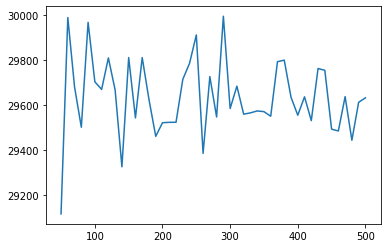

In [ ]:
sns.lineplot(n_of_estimators, RF_score)

In [ ]:
RF_score = rmse_cv(my_RFR)
print(RF_score.mean())

29584.45245659561


In [ ]:
prices_prediction = my_RFR.predict(X_test)
prices_prediction = prices_prediction[:, np.newaxis]
submission.SalePrice = prices_prediction
submission.head()

,SalePrice
Id,
1461,122964.336
1462,151907.702
1463,172379.788
1464,183301.600
1465,216627.661


In [ ]:
submission.to_csv('../content/gdrive/My Drive/Colab Notebooks/Kaggle/HousePrices/submission3.csv')

**Baseline model(lightGBM)**